In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images in the notebook
def display_image(image, title='Image'):
    """Displays an image using Matplotlib."""
    # OpenCV loads images in BGR format, so we convert to RGB for Matplotlib
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Libraries imported successfully!")

Libraries imported successfully!


# Part 1: Image Processing & Hough Circle Transform (Baseline Model)

This method uses traditional computer vision techniques to find circles. It doesn't require "training" with a large dataset but is very sensitive to parameter tuning. This is a great starting point and aligns with the models mentioned in your proposal

## Step 1.1: Load and Preprocess the Image

We need to load the image and prepare it for circle detection. This often involves converting to grayscale and applying a blur to reduce noise. Your provided image (image_3195a3.jpg) is already in grayscale

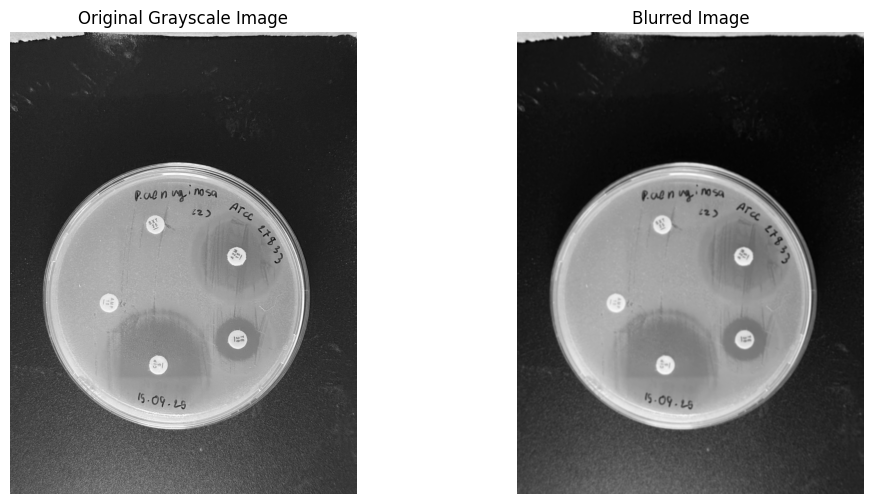

In [3]:
# Load the original image
# Make sure the file 'image_3195a3.jpg' is in the same directory as your notebook
try:
    img_original = cv2.imread('20250919_033735159_iOS.jpg', cv2.IMREAD_GRAYSCALE)
    if img_original is None:
        raise FileNotFoundError("Image file not found or could not be opened.")

    # Apply a Gaussian Blur to reduce noise and prevent false circle detection
    # The (9, 9) kernel size can be tuned. A larger kernel means more blur.
    img_blurred = cv2.GaussianBlur(img_original, (9, 9), 2)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Original Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_blurred, cmap='gray')
    plt.title('Blurred Image')
    plt.axis('off')
    plt.show()

except FileNotFoundError as e:
    print(e)

## Step 1.2: Apply Hough Circle Transform

Now we'll use OpenCV's HoughCircles function. The key to making this work is tuning the parameters correctly.

dp: Inverse ratio of the accumulator resolution. 1 is usually fine.

minDist: Minimum distance between the centers of detected circles.

param1: Higher threshold for the Canny edge detector.

param2: Accumulator threshold for circle centers. A lower value means more (and possibly false) circles are detected.

minRadius, maxRadius: The range of circle radii (in pixels) to look for.

In [4]:
# Create a color copy of the original image to draw circles on for visualization
img_with_circles = cv2.cvtColor(img_original, cv2.COLOR_GRAY2BGR)

# --- Parameter Tuning is CRITICAL here ---
# These values will likely need adjustment for different images/lighting
dp = 1.2
minDist = 50        # Minimum distance between circle centers
param1 = 100        # Canny edge detection higher threshold
param2 = 45         # Accumulator threshold (lower means more circles)
minRadius = 35      # Minimum radius of the circle to detect
maxRadius = 100     # Maximum radius of the circle to detect

# Detect circles using HoughCircles
circles = cv2.HoughCircles(img_blurred,
                           cv2.HOUGH_GRADIENT,
                           dp=dp,
                           minDist=minDist,
                           param1=param1,
                           param2=param2,
                           minRadius=minRadius,
                           maxRadius=maxRadius)

# Ensure circles were found before proceeding
if circles is not None:
    # Convert the (x, y, r) coordinates to integers
    circles = np.uint16(np.around(circles))
    print(f"Found {len(circles[0])} circles!")

    # Loop over all detected circles and draw them
    for i in circles[0, :]:
        # Draw the outer circle (green)
        cv2.circle(img_with_circles, (i[0], i[1]), i[2], (0, 255, 0), 3)
        # Draw the center of the circle (red)
        cv2.circle(img_with_circles, (i[0], i[1]), 2, (0, 0, 255), 3)

    # Display the result
    display_image(img_with_circles, 'Detected Circles (Hough Transform)')
else:
    print("No circles were found with the current parameters.")

No circles were found with the current parameters.


# Part 2: Deep Learning with YOLO (Advanced Model) 🤖

This is a much more powerful and robust approach. Instead of manually tuning parameters, we will train a neural network to learn what an inhibition zone looks like. Your proposal mentions YOLOv7, which is a great choice. I'd also suggest looking at YOLOv8, as it's the latest version from Ultralytics and is often easier to use. "YOLOv12" does not exist yet.

## Step 2.1: CRITICAL - Data Annotation

YOLO requires labeled data. This is the most important and time-consuming part of the process. You need to manually draw bounding boxes around every inhibition zone in your training images.

Get an Annotation Tool: Use a free tool like Roboflow, LabelImg, or CVAT.

Annotate Your Images: For every image in your images_original folder, you will draw a box around each inhibition zone. You will assign a class to it, for example, "inhibition_zone".

Export in YOLO Format: The tool will generate a .txt file for each image. This file contains the class and coordinates of each box.

Your images_original folder will have corresponding .txt files in a labels folder.

[Image showing the process of drawing bounding boxes on a petri dish image in LabelImg]

Step 2.2: Setup Project Structure and

In [5]:
import os
import shutil
import random

# --- Configuration ---
# The path to your folder with all original images and .txt labels
SOURCE_DIR = os.path.join('images_original')

# The base directory where the new YOLO structure will be created
BASE_OUTPUT_DIR = os.path.join('datasets', 'inhibition_zones')

# The ratio for the training set (e.g., 0.8 means 80% for training, 20% for validation)
TRAIN_RATIO = 0.8
# --- End Configuration ---

def split_data():
    """
    Splits images and labels from a source directory into train and validation sets
    for YOLO training.
    """
    if not os.path.isdir(SOURCE_DIR):
        print(f"ERROR: Source directory not found at '{SOURCE_DIR}'")
        return

    # Create the required directory structure
    train_img_path = os.path.join(BASE_OUTPUT_DIR, 'images', 'train')
    val_img_path = os.path.join(BASE_OUTPUT_DIR, 'images', 'val')
    train_lbl_path = os.path.join(BASE_OUTPUT_DIR, 'labels', 'train')
    val_lbl_path = os.path.join(BASE_OUTPUT_DIR, 'labels', 'val')

    for path in [train_img_path, val_img_path, train_lbl_path, val_lbl_path]:
        os.makedirs(path, exist_ok=True)
        
    # Get a list of all image files
    all_images = [f for f in os.listdir(SOURCE_DIR) if f.lower().endswith('.jpg')]
    random.shuffle(all_images)
    
    split_index = int(len(all_images) * TRAIN_RATIO)
    train_files = all_images[:split_index]
    val_files = all_images[split_index:]

    # Function to move files
    def move_files(file_list, dest_img_path, dest_lbl_path):
        moved_count = 0
        for img_file in file_list:
            base_name = os.path.splitext(img_file)[0]
            lbl_file = f"{base_name}.txt"
            
            src_img = os.path.join(SOURCE_DIR, img_file)
            src_lbl = os.path.join(SOURCE_DIR, lbl_file)
            
            # Move image
            shutil.move(src_img, os.path.join(dest_img_path, img_file))
            
            # Move corresponding label file, if it exists
            if os.path.exists(src_lbl):
                shutil.move(src_lbl, os.path.join(dest_lbl_path, lbl_file))
            else:
                print(f"Warning: Label file '{lbl_file}' not found for image '{img_file}'.")
            
            moved_count += 1
        return moved_count

    print("--- Starting Data Split ---")
    print(f"Moving {len(train_files)} files to the training set...")
    move_files(train_files, train_img_path, train_lbl_path)
    
    print(f"Moving {len(val_files)} files to the validation set...")
    move_files(val_files, val_img_path, val_lbl_path)
    
    print("\nData splitting complete! 🎉 Your 'datasets' folder is ready for training.")

if __name__ == '__main__':
    split_data()

ERROR: Source directory not found at 'images_original'


In [6]:
import os
import pandas as pd
from docx import Document

# --- Configuration ---
# Set the path to the folder containing your .docx files
tables_folder_path = 'Tables'
# Set the name for the output CSV file
output_csv_file = 'ground_truth_measurements.csv'
# --- End Configuration ---

# A list to hold all the data extracted from the tables
all_rows_data = []

print(f"Starting data extraction from '{tables_folder_path}'...")

# Loop through every file in the specified directory
for filename in os.listdir(tables_folder_path):
    # Check if the file is a Word document
    if filename.endswith('.docx'):
        file_path = os.path.join(tables_folder_path, filename)
        
        try:
            # Open the Word document
            doc = Document(file_path)
            
            # Check if the document has any tables
            if not doc.tables:
                print(f"Warning: No tables found in {filename}. Skipping.")
                continue
            
            # Assume the data is in the first table of the document
            table = doc.tables[0]
            
            # Get the header from the first row of the table
            header = [cell.text.strip() for cell in table.rows[0].cells]

            # Loop through the rest of the rows in the table (skip the header)
            for row in table.rows[1:]:
                row_data = [cell.text.strip() for cell in row.cells]
                
                # Create a dictionary for this row (e.g., {'Abbreviation': 'CPD', ...})
                row_dict = dict(zip(header, row_data))
                
                # Add the source filename for reference
                row_dict['source_file'] = filename
                
                # Add the extracted data to our main list
                all_rows_data.append(row_dict)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Check if we extracted any data
if not all_rows_data:
    print("No data was extracted. Please check the folder path and file contents.")
else:
    # Convert the list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(all_rows_data)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv_file, index=False)
    
    print("\nExtraction complete! 🎉")
    print(f"Data for {len(df)} antibiotics from {len(df['source_file'].unique())} files saved to '{output_csv_file}'.")
    
    # Display the first 5 rows of the new CSV file
    print("\n--- First 5 rows of your new dataset ---")
    print(df.head())

Starting data extraction from 'Tables'...


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Tables'

## Train YOLO

In [12]:


from ultralytics import YOLO

# Load a pretrained YOLOv8 model (e.g., yolov8n.pt is small and fast)
# The model will learn from these pretrained weights (transfer learning)
model = YOLO('yolov8n.pt')

# Train the model
# This will start the training process. It will take time and requires a decent GPU.
# It will save the results, including the best model weights, in a 'runs' folder.
results = model.train(data='data.yaml', epochs=50, imgsz=640)

print("Training complete!")
print("Best model weights saved at: runs/detect/train/weights/best.pt")

New https://pypi.org/project/ultralytics/8.3.217 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.206  Python-3.12.5 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=N

c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      1.86G          0      101.4          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.7it/s 2.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.0it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      1.89G          0      84.06          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.1it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      1.89G          0      73.15          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.2it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50       1.9G          0      70.88          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 5.8it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50       1.9G          0      68.14          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.7it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50       1.9G          0      61.75          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.6it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50       1.9G          0      56.11          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.3it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 7.2it/s 0.3s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50       1.9G          0      52.48          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.3it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.8it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50       1.9G          0      48.29          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 7.2it/s 0.3s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50       1.9G          0      44.98          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.3it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 7.1it/s 0.3s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50       1.9G          0      41.48          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.3it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 7.1it/s 0.3s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50       1.9G          0      37.84          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.6it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50       1.9G          0      34.63          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.7it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50       1.9G          0      32.11          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.3it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.6it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50       1.9G          0      29.71          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.5it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50       1.9G          0      27.02          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.3it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 7.3it/s 0.3s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50       1.9G          0      24.76          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.7it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50       1.9G          0      22.73          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 5.8it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50       1.9G          0      21.47          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.8it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50       1.9G          0      20.46          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.6it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50       1.9G          0      18.35          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.6it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50       1.9G          0      16.85          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.8it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50       1.9G          0      15.52          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.7it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50       1.9G          0      14.23          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.8it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50       1.9G          0      13.05          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 5.9it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50       1.9G          0      12.06          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.0it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50       1.9G          0      11.16          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.7it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.5it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50       1.9G          0      10.86          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.0it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50       1.9G          0      9.948          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.3it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50       1.9G          0      9.238          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.6it/s 2.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 5.8it/s 0.3s0.8s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50       1.9G          0      8.644          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.2it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50       1.9G          0      8.085          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.5it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50       1.9G          0      7.626          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.0it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50       1.9G          0      7.136          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.5it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50       1.9G          0      6.736          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.6it/s 2.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.7it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50       1.9G          0      6.367          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.5it/s 2.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 7.1it/s 0.3s0.7s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50       1.9G          0      6.023          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.6it/s 2.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 8.2it/s 0.2s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50       1.9G          0      5.735          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.5it/s 2.7s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 8.3it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50       1.9G          0      5.491          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.6it/s 2.6s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 7.8it/s 0.3s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50       1.9G          0      5.272          0          0        640: 100% ━━━━━━━━━━━━ 12/12 4.1it/s 2.9s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 8.2it/s 0.2s0.6s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50       1.9G          0      5.093          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 9.3it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50       1.9G          0      4.913          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.3it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 9.5it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50       1.9G          0      4.762          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 8.9it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50       1.9G          0      4.618          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 8.8it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50       1.9G          0      4.513          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 9.0it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50       1.9G          0       4.43          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 9.2it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50       1.9G          0      4.352          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 9.3it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50       1.9G          0      4.299          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 9.1it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50       1.9G          0      4.265          0          0        640: 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 8.9it/s 0.2s0.5s
                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:850: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



50 epochs completed in 0.057 hours.
Optimizer stripped from C:\code\git\Senior_project\doi_10_5061_dryad_5dv41nsfj__v20241013\runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from C:\code\git\Senior_project\doi_10_5061_dryad_5dv41nsfj__v20241013\runs\detect\train\weights\best.pt, 6.2MB

Validating C:\code\git\Senior_project\doi_10_5061_dryad_5dv41nsfj__v20241013\runs\detect\train\weights\best.pt...
Ultralytics 8.3.206  Python-3.12.5 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 6.6it/s 0.3s0.5s


c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Lukme\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
c:\Users\Lukme\AppData\Local\

                   all         45          0          0          0          0          0
WARNING no labels found in detect set, can not compute metrics without labels
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to C:\code\git\Senior_project\doi_10_5061_dryad_5dv41nsfj__v20241013\runs\detect\train
Training complete!
Best model weights saved at: runs/detect/train/weights/best.pt


## Run Inference (Make Predictions)

In [ ]:
from ultralytics import YOLO

# Load your custom-trained model
model_path = 'runs/detect/train/weights/best.pt'
try:
    model = YOLO(model_path)

    # Path to a new image you want to test
    test_image_path = 'image_3195a3.jpg' # Using our example image

    # Run inference
    results = model(test_image_path)

    # The results object contains all the information. We can plot it directly.
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        display_image(im_array, title='YOLOv8 Predictions')

except Exception as e:
    print(f"Error loading model or running inference: {e}")
    print("Did you train the model first and is the path correct?")


--- Starting Inference with Custom Model (Drawing Circles) ---
Running prediction on: datasets/inhibition_zones/images/val/1.3.1. original.jpg

image 1/1 c:\code\git\Senior_project\doi_10_5061_dryad_5dv41nsfj__v20241013\datasets\inhibition_zones\images\val\1.3.1. original.jpg: 640x640 (no detections), 61.7ms
Speed: 9.1ms preprocess, 61.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

Found 0 inhibition zones. Drawing circles...


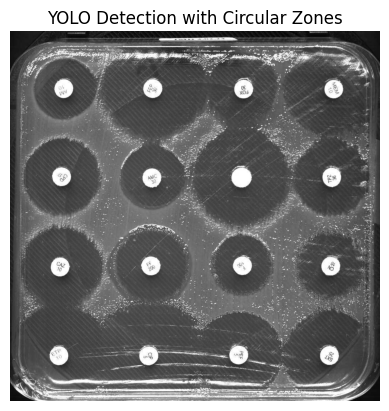

In [15]:
# ===================================================================
# Part 3: Run Inference and Draw CIRCLES
# ===================================================================
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

print("\n--- Starting Inference with Custom Model (Drawing Circles) ---")

# Define the path to your best trained model weights
model_path = 'runs/detect/train/weights/best.pt'

# Define the path to an image you want to test
test_image_path = 'datasets/inhibition_zones/images/val/1.3.1. original.jpg' # Example path

if not os.path.exists(model_path):
    print(f"ERROR: Model file not found at '{model_path}'")
elif not os.path.exists(test_image_path):
    print(f"ERROR: Test image not found at '{test_image_path}'")
else:
    try:
        # Load your custom model
        custom_model = YOLO(model_path)
        
        # Run prediction
        print(f"Running prediction on: {test_image_path}")
        results = custom_model(test_image_path)

        # Get the first result object
        r = results[0]
        
        # Load the original image using OpenCV to draw on it
        annotated_image = r.orig_img.copy()

        print(f"\nFound {len(r.boxes)} inhibition zones. Drawing circles...")
        for box in r.boxes:
            # Get bounding box coordinates in (center_x, center_y, width, height) format
            xywh = box.xywh[0].tolist()
            center_x, center_y, width, height = xywh
            
            # --- Calculate Circle Parameters ---
            # Radius is the average of half the width and half the height
            radius = int((width + height) / 4)
            center_point = (int(center_x), int(center_y))
            
            # Draw the outer circle on the image
            #   - center_point: The (x, y) coordinates of the circle's center
            #   - radius: The circle's radius in pixels
            #   - (0, 255, 0): The color of the circle in BGR format (green)
            #   - 3: The thickness of the circle's line
            cv2.circle(annotated_image, center_point, radius, (0, 255, 0), 3)

        # Display the final image with circular annotations
        display_image(annotated_image, title='YOLO Detection with Circular Zones')

    except Exception as e:
        print(f"An error occurred during inference: {e}")

# Image enchance

## Contrast Limited Adaptive Histogram Equalization (CLAHE).

Step 1: Image loaded successfully.
Step 2: CLAHE applied to enhance local contrast.
Step 3: Image binarized to clearly separate zones.


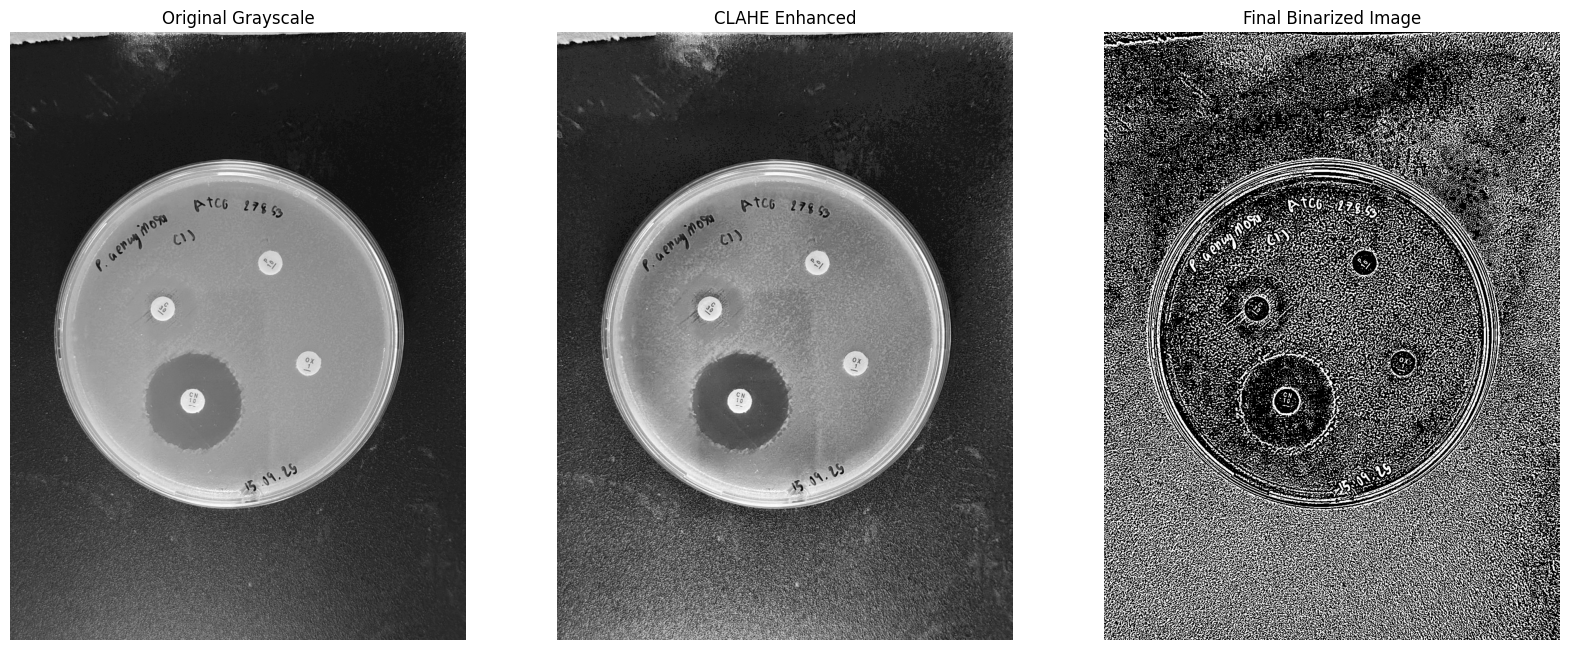

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images in the notebook
def display_images(images, titles):
    """Displays multiple images side-by-side."""
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        # Display in grayscale
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# --- Configuration ---
# Use one of the images from your dataset
image_path = '20250919_033735892_iOS.jpg'
# ---

# 1. Load the image in grayscale
try:
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
        
    print("Step 1: Image loaded successfully.")

    # 2. Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
    # This technique improves contrast locally, making it ideal for uneven lighting.
    # clipLimit: Threshold for contrast limiting (prevents over-amplifying noise).
    # tileGridSize: Divides the image into a grid to apply equalization on each part.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    print("Step 2: CLAHE applied to enhance local contrast.")

    # 3. Binarize the image using Adaptive Thresholding
    # This converts the grayscale image to black and white, making zones distinct.
    # ADAPTIVE_THRESH_GAUSSIAN_C is effective for variable lighting.
    # 11 is the block size (size of a pixel neighborhood).
    # 2 is a constant subtracted from the mean.
    img_binary = cv2.adaptiveThreshold(
        img_clahe, 
        255, # Max value to assign
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, # Invert the threshold to make zones white
        15, # Block size must be odd
        4   # Constant to subtract
    )
    print("Step 3: Image binarized to clearly separate zones.")

    # 4. Display the results
    display_images(
        [img_gray, img_clahe, img_binary], 
        ['Original Grayscale', 'CLAHE Enhanced', 'Final Binarized Image']
    )

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

## Image Enhancement with Morphological Opening
The process involves first creating the binary image as before, and then applying the "opening" operation. An opening is simply an erosion followed by a dilation.

Erosion: Shrinks the boundaries of white regions, effectively removing small, isolated white dots (the "salt").

Dilation: Expands the boundaries of the remaining white regions, restoring the main objects to their original size.

The net result is the removal of small noise without significantly affecting the larger, important shapes.

Morphological opening applied to remove noise.


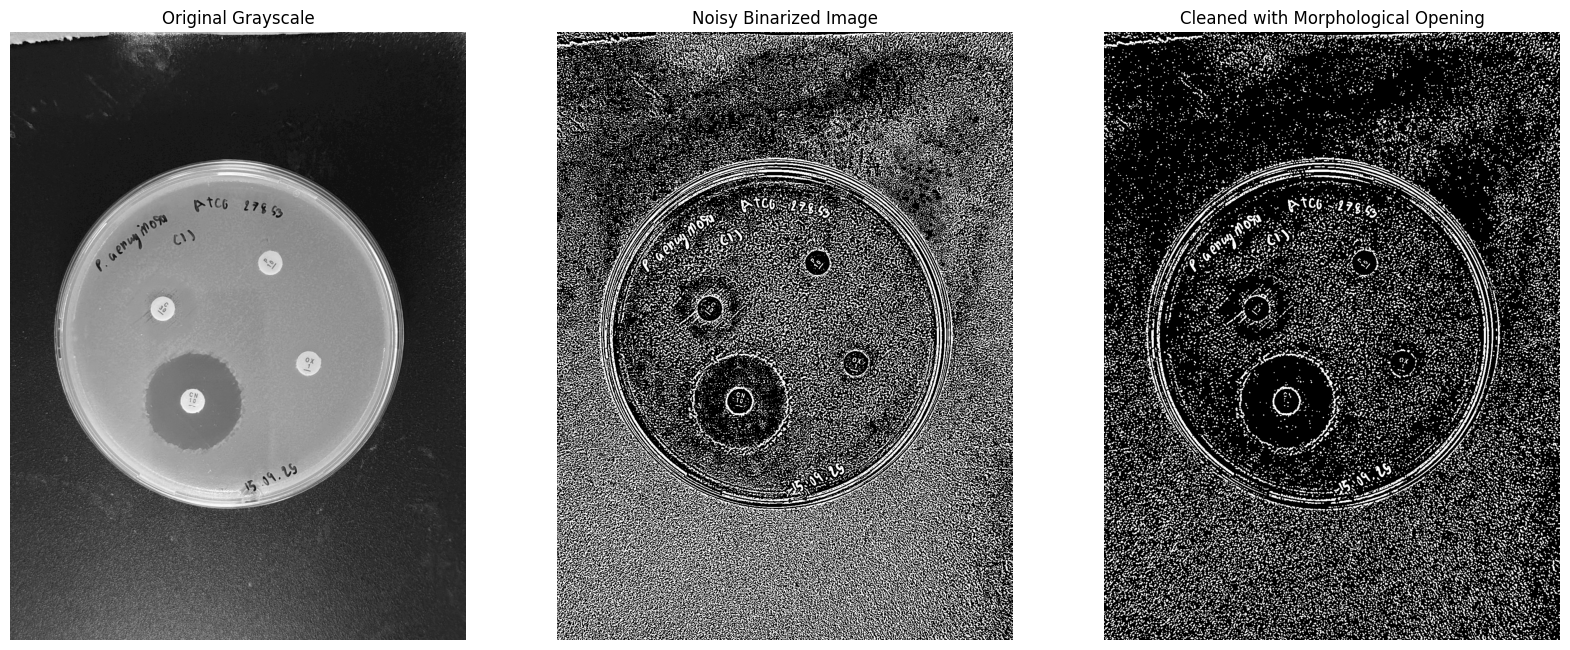

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images
def display_images(images, titles):
    """Displays multiple images side-by-side."""
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# --- Configuration ---
image_path = '20250919_033735892_iOS.jpg'
# ---

try:
    # 1. Load image and apply CLAHE (same as before)
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)

    # 2. Binarize the image using Adaptive Thresholding (same as before)
    img_binary_noisy = cv2.adaptiveThreshold(
        img_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 4
    )

    # 3. ✨ NEW STEP: Clean the image with Morphological Opening
    # Define a 'kernel', which is the structural element for the operation.
    # A 3x3 circle is a good choice for removing small, dot-like noise.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    # Apply the opening operation
    img_binary_cleaned = cv2.morphologyEx(img_binary_noisy, cv2.MORPH_OPEN, kernel, iterations=1)
    
    print("Morphological opening applied to remove noise.")

    # 4. Display all steps to see the improvement
    display_images(
        [img_gray, img_binary_noisy, img_binary_cleaned],
        ['Original Grayscale', 'Noisy Binarized Image', 'Cleaned with Morphological Opening']
    )

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")


Found 489 potential inhibition zones.


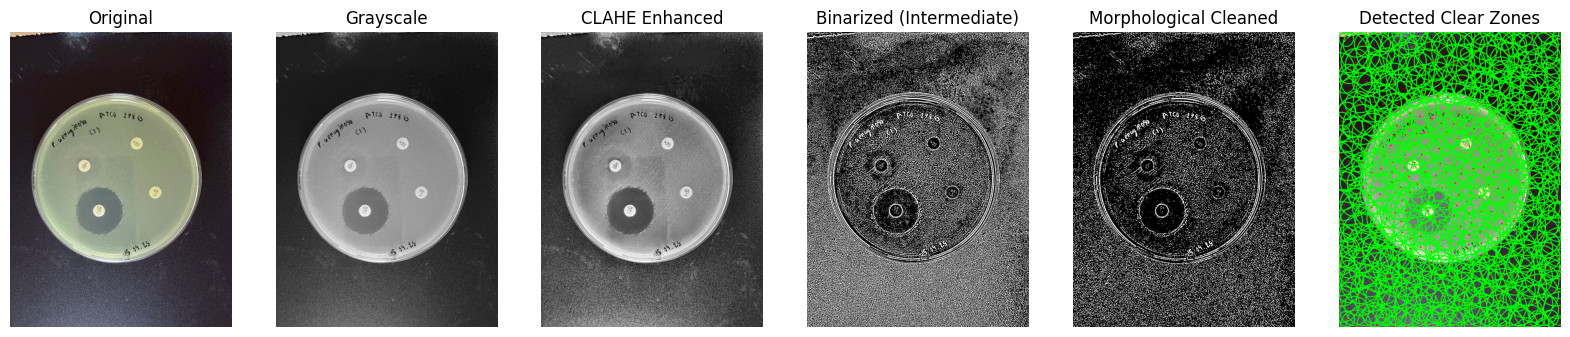


Detected Inhibition Zones (Pixel Dimensions):
Zone 1: Center=(172, 1130), Radius=99 pixels
Zone 2: Center=(296, 1228), Radius=99 pixels
Zone 3: Center=(500, 1256), Radius=99 pixels
Zone 4: Center=(886, 1090), Radius=99 pixels
Zone 5: Center=(672, 1262), Radius=99 pixels
Zone 6: Center=(214, 1266), Radius=99 pixels
Zone 7: Center=(434, 1298), Radius=99 pixels
Zone 8: Center=(710, 1226), Radius=99 pixels
Zone 9: Center=(732, 1280), Radius=99 pixels
Zone 10: Center=(232, 1332), Radius=99 pixels
Zone 11: Center=(268, 1176), Radius=99 pixels
Zone 12: Center=(760, 1374), Radius=99 pixels
Zone 13: Center=(156, 1300), Radius=99 pixels
Zone 14: Center=(374, 1376), Radius=99 pixels
Zone 15: Center=(382, 1320), Radius=99 pixels
Zone 16: Center=(578, 1296), Radius=99 pixels
Zone 17: Center=(880, 1300), Radius=99 pixels
Zone 18: Center=(608, 1356), Radius=99 pixels
Zone 19: Center=(760, 1222), Radius=99 pixels
Zone 20: Center=(362, 1228), Radius=99 pixels
Zone 21: Center=(874, 1156), Radius=99 pix

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images in the notebook
def display_images(images, titles):
    """Displays multiple images side-by-side."""
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        # Convert BGR to RGB for matplotlib if it's a color image
        if len(images[i].shape) == 3 and images[i].shape[2] == 3:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# --- Configuration ---
# Path to your new example image
image_path = '20250919_033735892_iOS.jpg' # Make sure this file is in the same directory as your script/notebook
# ---

try:
    # 1. Load the original image
    img_original = cv2.imread(image_path)
    if img_original is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # 2. Convert to grayscale
    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

    # 3. Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)

    # 4. Binarize the image using Adaptive Thresholding
    # Note: For this image, the clear zone is darker. So we might not need INV.
    # Let's try regular THRESH_BINARY first and see.
    img_binary = cv2.adaptiveThreshold(
        img_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, # Use INV if clear zones are darker than background
        15, # Block size
        4   # Constant to subtract
    )

    # 5. Apply Morphological Opening to clean noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    img_cleaned = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # 6. Apply Hough Circle Transform on the cleaned binary image to find clear zones
    # Create a copy of the original image to draw on
    img_with_circles = img_original.copy()

    # Parameters for HoughCircles:
    # dp: Inverse ratio of the accumulator resolution. 1 means same res as image.
    # minDist: Minimum distance between the centers of detected circles.
    # param1: Higher threshold for Canny edge detector.
    # param2: Accumulator threshold for the circle centers. Smaller value means more circles.
    # minRadius, maxRadius: Min and Max radius in pixels to search for.

    # *** IMPORTANT TUNING BASED ON YOUR IMAGE ***
    # We need to estimate typical pixel sizes for the 6mm disks and the inhibition zones.
    # The actual values below are estimates and WILL NEED ADJUSTMENT.
    # For example, if a 6mm disk is ~20-30 pixels, an inhibition zone might be 40-100 pixels.
    # You'll need to visually inspect your images and adjust minRadius/maxRadius accordingly.
    
    # Let's try to detect the dark clear zone.
    # The 'param2' is crucial. Lower it to find fainter circles.
    # The radius range should be larger than the antibiotic disks.
    
    circles = cv2.HoughCircles(
        img_cleaned, # Use the cleaned binary image
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=50,   # Minimum distance between circle centers (adjust based on disk proximity)
        param1=100,   # Canny threshold (high for distinct edges)
        param2=20,    # Accumulator threshold (lower to detect more circles, but increases false positives)
        minRadius=30, # Estimated minimum radius of an inhibition zone in pixels (larger than disk)
        maxRadius=100 # Estimated maximum radius of an inhibition zone in pixels
    )

    detected_zones = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        print(f"\nFound {len(circles[0])} potential inhibition zones.")
        for i in circles[0, :]:
            # Draw the outer circle (green)
            cv2.circle(img_with_circles, (i[0], i[1]), i[2], (0, 255, 0), 3)
            # Draw the center of the circle (red)
            cv2.circle(img_with_circles, (i[0], i[1]), 2, (0, 0, 255), 3)
            detected_zones.append({'center_x': i[0], 'center_y': i[1], 'radius': i[2]})
    else:
        print("\nNo inhibition zones detected. Try adjusting Hough Circle parameters.")

    # 7. Display all intermediate and final results
    display_images(
        [img_original, img_gray, img_clahe, img_binary, img_cleaned, img_with_circles],
        ['Original', 'Grayscale', 'CLAHE Enhanced', 'Binarized (Intermediate)', 'Morphological Cleaned', 'Detected Clear Zones']
    )
    
    if detected_zones:
        print("\nDetected Inhibition Zones (Pixel Dimensions):")
        for idx, zone in enumerate(detected_zones):
            print(f"Zone {idx+1}: Center=({zone['center_x']}, {zone['center_y']}), Radius={zone['radius']} pixels")

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

Step 1: Sigmoid function applied for high-contrast separation.
Step 2: Otsu's Binarization applied to create the final clear image.


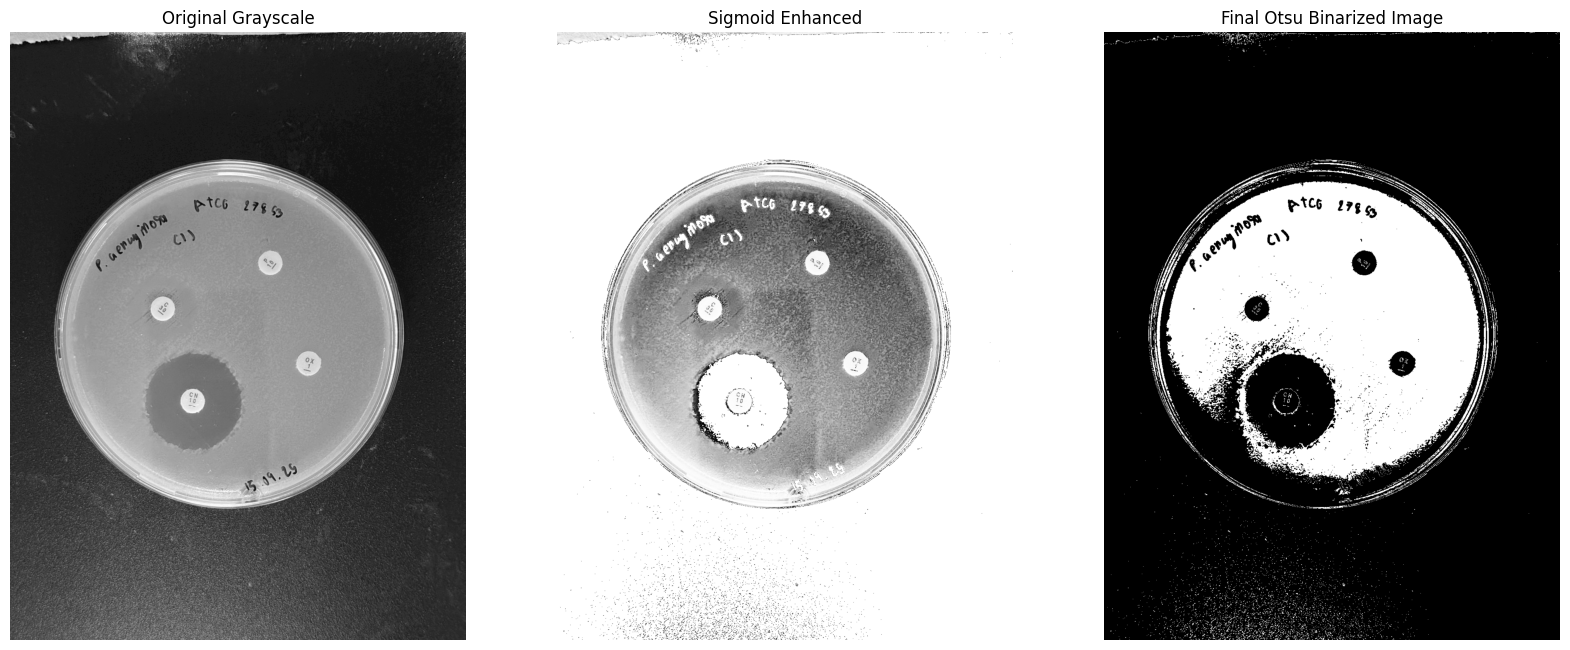

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images
def display_images(images, titles):
    """Displays multiple images side-by-side."""
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# --- Configuration ---
image_path = '20250919_033735892_iOS.jpg' # Path to your example image
# ---

try:
    # 1. Load the original image in grayscale
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # 2. Apply Sigmoid function for extreme contrast enhancement
    # Normalize pixel values from [0, 255] to a range like [-10, 10] for the sigmoid function
    # A higher gain (e.g., 0.1) creates a sharper transition
    gain = 0.05 
    img_normalized = (img_gray - 128) * gain
    
    # Apply the sigmoid function
    img_sigmoid = 1 / (1 + np.exp(-img_normalized))
    
    # Scale back to 0-255 and convert to an 8-bit image
    img_sigmoid_enhanced = (img_sigmoid * 255).astype(np.uint8)
    print("Step 1: Sigmoid function applied for high-contrast separation.")

    # 3. Apply Otsu's Binarization
    # This method automatically finds the best threshold value.
    # We use THRESH_BINARY_INV because the zones of interest are dark.
    # The '+' operator combines the two flags.
    ret, img_otsu = cv2.threshold(
        img_sigmoid_enhanced, 
        0, # Threshold value is ignored when Otsu is used
        255, 
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    print("Step 2: Otsu's Binarization applied to create the final clear image.")

    # 4. Display the results to see the improvement at each step
    display_images(
        [img_gray, img_sigmoid_enhanced, img_otsu],
        ['Original Grayscale', 'Sigmoid Enhanced', 'Final Otsu Binarized Image']
    )

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")